In [2]:
import cv2 # for image reading and processsing
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [3]:
img_files = np.array(glob("Obama/*"))

In [4]:
def distort_image(img, rot = 50, shift_px = 40):
    """
    Function to introduce random distortion: brightness, flip, rotation, and shift 
    """
    rows, cols,_ = img.shape
    choice = np.random.randint(5)
    #print(choice)
    if choice == 0:  # Randomly rotate 0-50 degreee
        rot *= np.random.random()   
        M = cv2.getRotationMatrix2D((cols/2,rows/2), rot, 1)
        dst = cv2.warpAffine(img,M,(cols,rows))
    elif choice == 1: # Randomly change the intensity
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
        hsv[:, :, 2] = hsv[:, :, 2] * ratio
        dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    elif choice == 2: # Randomly shift the image in horizontal and vertical direction
        x_shift,y_shift = np.random.randint(-shift_px,shift_px,2)
        M = np.float32([[1,0,x_shift],[0,1,y_shift]])
        dst = cv2.warpAffine(img,M,(cols,rows))
    elif choice == 3: # Randomly flip the image
        dst = np.fliplr(img)
    else:
        dst = img
    
    return dst

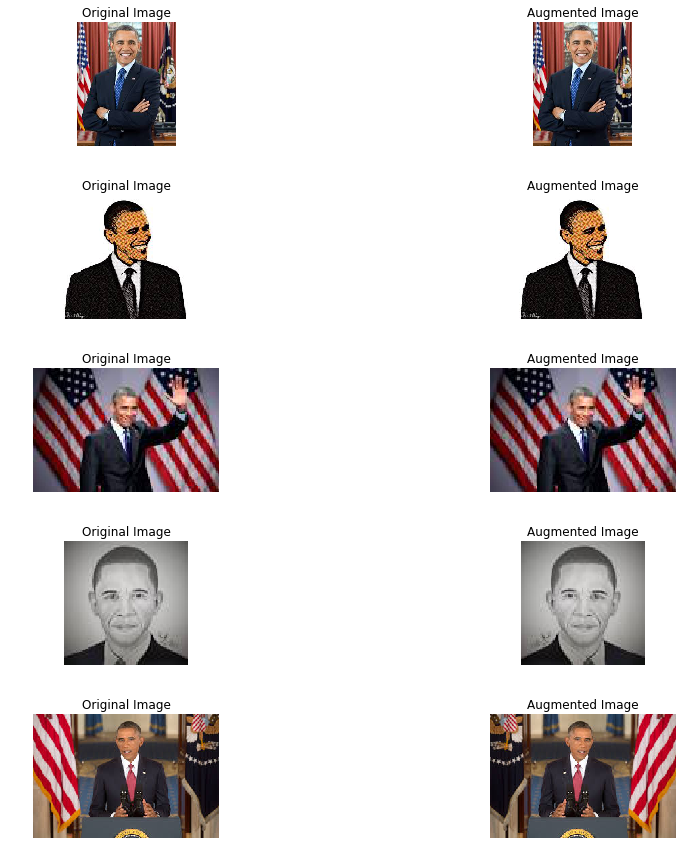

In [6]:
# Visualizing Augmented images
samples_per_row = 2
num_rows = 5
fig, ax = plt.subplots(num_rows,samples_per_row,figsize=(15,15))
fig.subplots_adjust(hspace = .4, wspace=.2)
ax = ax.ravel()

n_train = len(img_files)

for i in range(num_rows):
    #print(i)
    idX = np.random.randint(0, n_train)
    source = img_files[idX]
    image = cv2.imread(source)
    ax[2*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    ax[2*i].set_title('Original Image')
    ax[2*i].axis('off')
    img_new = distort_image(image)  # Distorted Images
    img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
    #print(img_crop.shape)
    ax[2*i+1].imshow(img_new) 
    ax[2*i+1].set_title('Augmented Image')
    ax[2*i+1].axis('off')
    

In [7]:
# data generator
def data_generator(samples, batch_size=32, validation_flag = False):
    """
    Function to generate data after, it reads the image files, performs random distortions and finally 
	returns a batch of training or validation data
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
           
            for batch_sample in batch_samples:
                if validation_flag:  # The validation data consists only of center image and without distortions
                    image = cv2.imread(batch_sample)
                    images.append(image)
                    continue
                else:  # In training dataset we introduce distortions to augment it and improve performance
                    image = cv2.imread(batch_sample)
                    # Randomly augment the training dataset to reduce overfitting
                    image = distort_image(image)
                    images.append(image)
                
                    

            # Convert the data into numpy arrays
            X_train = np.array(images)
            
            yield X_train  


In [8]:
train_generator = data_generator(img_files,  batch_size=32)